In [1]:
!rm -r Neural_Networks-demo/
!git clone https://github.com/KiranArun/Neural_Networks-demo.git
!python3 /content/Neural_Networks-demo/scripts/setup.py

Cloning into 'Neural_Networks-demo'...
remote: Counting objects: 114, done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 114 (delta 41), reused 87 (delta 23), pack-reused 0
Receiving objects: 100% (114/114), 1.20 MiB | 26.13 MiB/s, done.
Resolving deltas: 100% (41/41), done.


# MNIST Handwriten Digits Classifier

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# this is the directory where we will keep and external files, eg. data, logs
model_root_dir = '/content/Neural_Networks-demo/'

# get data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets(model_root_dir+'MNIST_data', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /content/Neural_Networks-demo/MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /content/Neural_Networks-demo/MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /content/Neural_Networks-demo/MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /content/Neural_Networks-demo/MNIS

In [0]:
image_size = 28
num_classes = 10

In [0]:
batch_size = 100
learning_rate = 0.2
dropout_rate = 0.4

epochs = 2
iterations = mnist.train.num_examples//batch_size

In [0]:
tf.reset_default_graph()

In [0]:
X_placeholder = tf.placeholder(shape=[None, image_size**2], dtype=tf.float32, name='X_placeholder')
Y_placeholder = tf.placeholder(shape=[None, num_classes], dtype=tf.int64, name='Y_placeholder')

# whether we are training or evaluating
# so we can apply dropout or not
is_training = tf.placeholder_with_default(input=False, shape=[], name='is_training')

# reshape the input image into tensorflows required format (N,H,W,C)
X_image = tf.reshape(X_placeholder, [-1,image_size,image_size,1])

In [0]:
# convolutional layer 1
conv1 = tf.layers.conv2d(inputs=X_image,
                         filters=8,
                         kernel_size=[5, 5],
                         activation=tf.nn.relu)

# max pool conv1
pool1 = tf.layers.max_pooling2d(inputs=conv1,
                                pool_size=[2, 2],
                                strides=2)

In [0]:
# convolutional layer 2
conv2 = tf.layers.conv2d(inputs=pool1,
                         filters=16,
                         kernel_size=[5, 5],
                         activation=tf.nn.relu)

# max pool conv2
pool2 = tf.layers.max_pooling2d(inputs=conv2,
                                pool_size=[2, 2],
                                strides=2)

In [0]:
# flatten for fc layers
pool2_flat = tf.reshape(pool2, [-1, 4 * 4 * 16])

# fc layer 1
fc1 = tf.layers.dense(inputs=pool2_flat,
                        units=256,
                        activation=tf.nn.relu)

# apply dropout to fc layer 1
dropout = tf.layers.dropout(inputs=fc1,
                            rate=dropout_rate,
                            training=is_training)

In [0]:
# output layer
Y_prediction = tf.layers.dense(inputs=dropout,
                               units=num_classes)

In [0]:
# define loss
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y_placeholder,
                                                                 logits=Y_prediction,
                                                                 name='loss'))

# define optimizer and training step
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

In [0]:
# compute accuracy
correct_prediction = tf.equal(tf.argmax(Y_prediction, 1), tf.argmax(Y_placeholder, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [0]:
# create session
sess = tf.InteractiveSession()
# initialize variables
sess.run(tf.global_variables_initializer())

In [15]:
# training

losses = np.array([])

for epoch in range(epochs):

    print('New epoch', str(epoch+1)+'/'+str(epochs))
    
    for idx in range(iterations):

        batch_xs, batch_ys = mnist.train.next_batch(batch_size, shuffle=True)

        _, _loss = sess.run([train_step, loss], 
                            feed_dict={
                                X_placeholder: batch_xs,
                                Y_placeholder: batch_ys,
                                is_training : True
                            })

        if (idx+1) % (iterations/5) == 0:

            _accuracy = sess.run(accuracy, feed_dict={X_placeholder : mnist.validation.images,
                                                      Y_placeholder : mnist.validation.labels,
                                                     })
            
            print('step', str(idx+1)+'/'+str(iterations), 'loss', _loss, 'accuracy', str(round(100*_accuracy,2))+'%')
            
        losses = np.append(losses, np.mean(_loss))

New epoch 1/2
step 110/550 loss 0.2454446 accuracy 94.12%
step 220/550 loss 0.074098065 accuracy 96.24%
step 330/550 loss 0.21147299 accuracy 96.82%
step 440/550 loss 0.09511683 accuracy 97.58%
step 550/550 loss 0.17868765 accuracy 97.96%
New epoch 2/2
step 110/550 loss 0.13529004 accuracy 97.88%
step 220/550 loss 0.06795734 accuracy 98.22%
step 330/550 loss 0.06448629 accuracy 98.3%
step 440/550 loss 0.16825433 accuracy 98.16%
step 550/550 loss 0.082564056 accuracy 98.44%


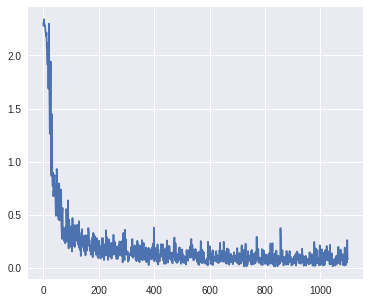

In [16]:
# plot training losses

fig, ax = plt.subplots(figsize=(6,5))
ax.plot(losses)
ax.grid(True)

In [17]:
# get evaluation accuracy
_accuracy = sess.run(accuracy, feed_dict={X_placeholder : mnist.test.images,
                                          Y_placeholder : mnist.test.labels
                                         })

print(str(round(100*_accuracy,2))+'%')

98.47%


prediction: 2 answer: 2
0 0.004%
1 0.053%
2 99.942%
3 0.0%
4 0.0%
5 0.0%
6 0.0%
7 0.0%
8 0.001%
9 0.0%


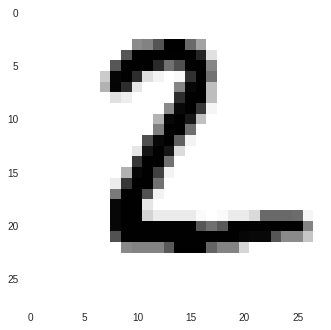

prediction: 6 answer: 6
0 0.002%
1 0.0%
2 0.0%
3 0.0%
4 0.0%
5 0.001%
6 99.995%
7 0.0%
8 0.002%
9 0.0%


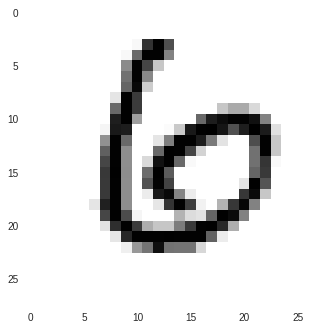

In [19]:
# test and show test images
test_idxs = [1,11]

for test_idx in test_idxs:
    test_x, test_y = mnist.test.images[test_idx], mnist.test.labels[test_idx]

    _prediction = sess.run(Y_prediction, feed_dict={X_placeholder: test_x.reshape(1,-1)})

    print('prediction:', np.argmax(_prediction), 'answer:', np.argmax(test_y))

    for i,val in enumerate(_prediction[0]):
        print(i, str(round(100*np.exp(val)/np.sum(np.exp(_prediction)),3))+'%')

    plt.imshow(test_x.reshape(image_size,image_size), cmap='binary')
    plt.grid(False)
    plt.show()